In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

Ensure that the spiral pupil function gives the expected Fourier transform.

## Pupil phase map

In [2]:
from gen_phasemap import gen_phasemap
from spirals import binarized_ringed

# This is the pupil function
def binarized_ringed_650(r, phi):
    phase = 650.*1e-9 # actually OPD
    return binarized_ringed(r, phi, phase)

# Values pulled from a recent run of proper for the toliman config 
gridsize = 2048
sampling = 0.00036621093749999995 # m/sample
phasemap = gen_phasemap(binarized_ringed_650, gridsize, 0.00036621093749999995, use_cached=True, save_cached=True)

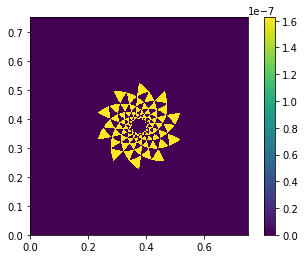

In [3]:
import matplotlib.pyplot as plt
plt.imshow(phasemap,cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.colorbar()
plt.show()

## Pupil plane wavefront

In [4]:
import numpy as np
import math
aperture = np.ones((gridsize,gridsize), dtype=complex)
# Exclude inner and outer regions corresponding to those defined in Keiran's original code
c = gridsize/2.
scale = 0.15/300.
for i in range(gridsize):
    for j in range(gridsize):
        x = i - c
        y = j - c
        r = sampling*math.hypot(x,y)/scale
        if(r>300 or r<50):
            aperture[i][j] *= 0

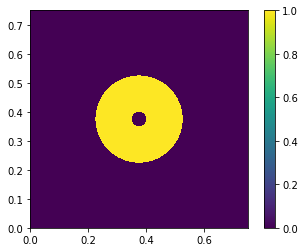

In [5]:
plt.imshow(np.abs(aperture),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.colorbar()
plt.show()

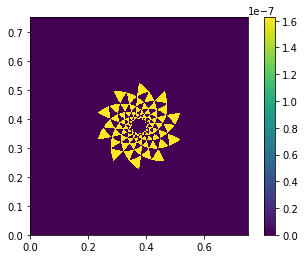

In [6]:
# Check pupil features are retained within this region
plt.imshow(np.abs(np.multiply(aperture,phasemap)),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.colorbar()
plt.show()

## Image plane PSF

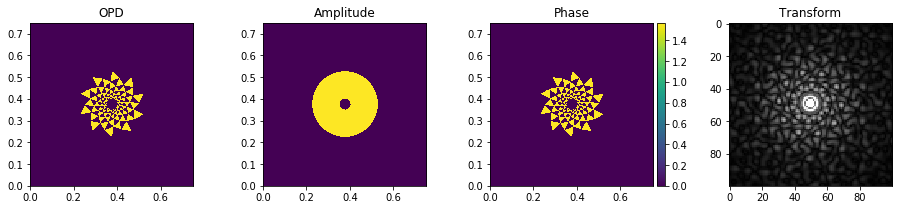

In [7]:
# single instance
import numpy as np
import math
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

wl=650.
fig, axes = plt.subplots(1, 4, figsize=(16,3))

plt.axes(axes[0])
plt.imshow(phasemap,cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
#plt.imshow(np.abs(np.multiply(aperture,phasemap)),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.title('OPD')

wf = np.exp((2*np.pi*complex(0., 1.)/(wl*1e-9))*phasemap)
# Retain only illuminated region
wf = np.multiply(wf, aperture)
plt.axes(axes[1])
plt.imshow(np.abs(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.title('Amplitude')

plt.axes(axes[2])
im = plt.imshow(np.angle(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.title('Phase')
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

# Calculate Fourier transform
ft = np.fft.fftshift(np.fft.fft2(wf))

plt.axes(axes[3])
# Peak value is around 500000, but clip at lower value to emphasise rest of image
im = plt.imshow(np.abs(ft[975:1075,975:1075]),vmax=60000, cmap=plt.get_cmap('gray'))
plt.title('Transform')

plt.show()

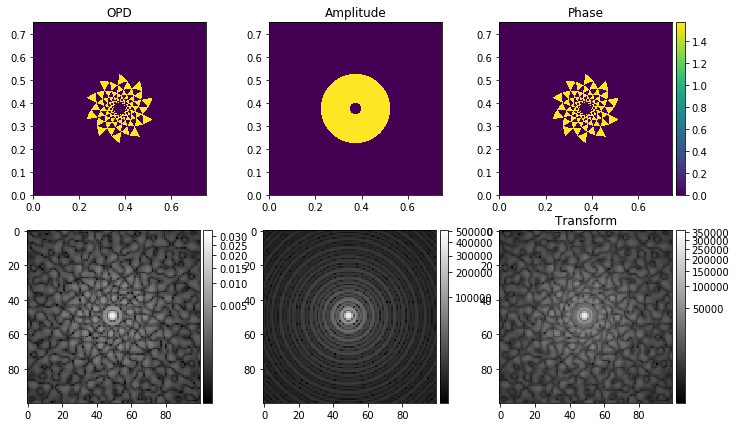

In [20]:
# Compare FTs of each step
import numpy as np
import math
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

wl=650.
fig, axes = plt.subplots(2, 3, figsize=(12,7))

plt.axes(axes[0][0])
plt.imshow(phasemap,cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.title('OPD')

plt.axes(axes[1][0])
im = plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(phasemap))[975:1075,975:1075]), cmap=plt.get_cmap('gray'),norm=mcolors.PowerNorm(gamma=0.3))
divider = make_axes_locatable(axes[1][0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

wf = np.exp((2*np.pi*complex(0., 1.)/(wl*1e-9))*phasemap)
# Retain only illuminated region
wf = np.multiply(wf, aperture)

plt.axes(axes[0][1])
plt.imshow(np.abs(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.title('Amplitude')

plt.axes(axes[1][1])
im = plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(aperture))[975:1075,975:1075]), cmap=plt.get_cmap('gray'),norm=mcolors.PowerNorm(gamma=0.3))
divider = make_axes_locatable(axes[1][1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.axes(axes[0][2])
im = plt.imshow(np.angle(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]])
plt.title('Phase')
divider = make_axes_locatable(axes[0][2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

# Calculate Fourier transform
ft = np.fft.fftshift(np.fft.fft2(wf))

plt.axes(axes[1][2])
# Peak value is around 500000, but clip at lower value to emphasise rest of image
im = plt.imshow(np.abs(ft[975:1075,975:1075]), cmap=plt.get_cmap('gray'),norm=mcolors.PowerNorm(gamma=0.3))
plt.title('Transform')
divider = make_axes_locatable(axes[1][2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

## Deconstruct wavefront

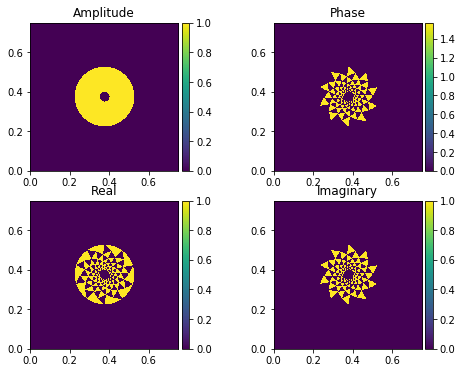

In [23]:
wl=650.
def wrapcb(im):
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

wf = np.multiply(np.exp((2*np.pi*complex(0., 1.)/(wl*1e-9))*phasemap), aperture)

fig, axes = plt.subplots(2, 2, figsize=(8,6))

plt.axes(axes[0][0])
plt.title('Amplitude')
wrapcb(plt.imshow(np.abs(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))

plt.axes(axes[0][1])
plt.title('Phase')
wrapcb(plt.imshow(np.angle(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))

plt.axes(axes[1][0])
plt.title('Real')
wrapcb(plt.imshow(np.real(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))

plt.axes(axes[1][1])
plt.title('Imaginary')
wrapcb(plt.imshow(np.imag(wf),cmap='viridis',extent=[x*sampling for x in [0,gridsize,0,gridsize]]))


plt.show()

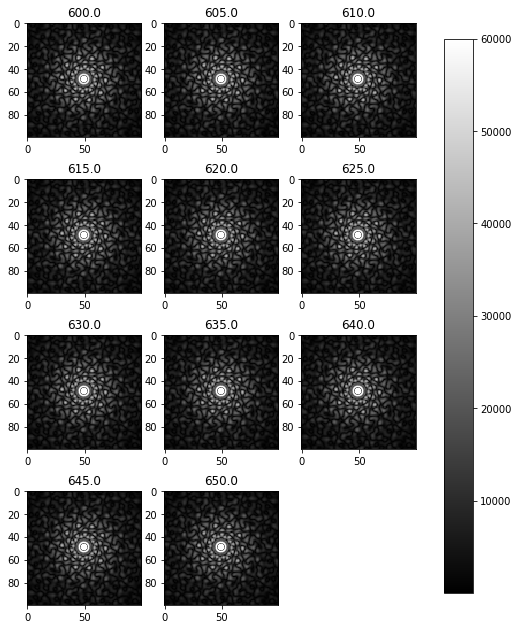

In [8]:
import numpy as np
import math
import matplotlib.colors as mcolors

# Match Kieran's 11 wavelengths spanning 600 to 650nm inclusive
delta = 5. #nm
n_wl = 11
fig, axes = plt.subplots(4, 3, figsize=(8,11))
for wl,ax in zip([600.+delta*d for d in range(n_wl)], axes.reshape(-1)):
    # Convert OPDS in phasemap to wavelength-specific complex phase 
    wf = np.exp((2*np.pi*complex(0., 1.)/(wl*1e-9))*phasemap)
    
    # Retain only illuminated region
    wf = np.multiply(wf, aperture)
    
    # Calculate Fourier transform
    ft = np.fft.fftshift(np.fft.fft2(wf))
    plt.axes(ax)
    # Peak value is around 500000, but clip at lower value to emphasise rest of image
    im = plt.imshow(np.abs(ft[975:1075,975:1075]),vmax=60000, cmap=plt.get_cmap('gray'))
    plt.title(wl)
axes[-1,-1].axis('off')    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


In [9]:
print(wl)

650.0


In [10]:
# Export FITS file
import pyfits
#print(sampling)
if False:
    hdu = pyfits.PrimaryHDU(np.abs(wf))
    hdu.writeto('pupil_abs_650.fits')
    hdu = pyfits.PrimaryHDU(np.angle(wf))
    hdu.writeto('pupil_phase_650.fits')
    ft = np.fft.fftshift(np.fft.fft2(wf))
    hdu = pyfits.PrimaryHDU(np.abs(ft))
    hdu.writeto('pupil_fft_abs_650.fits')
    hdu = pyfits.PrimaryHDU(np.angle(ft))
    hdu.writeto('pupil_fft_phase_650.fits')

/home/ubuntu/miniconda/envs/astroconda/lib/python3.5/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
